<a href="https://colab.research.google.com/github/eunjee/ML/blob/main/mfcc_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


# **MFCC구현**

- librosa 라이브러리 사용도 고려..

참조 - https://ratsgo.github.io/speechbook/docs/fe/mfcc

### 1. 음성파일 불러오기
- 지금은 예시 하나만 해놓음
- 경로 불러오는 것 수정해야함 
import os를 쓰던지 pathlib을 쓰던지 
- 음성 downsampling해야함 (미정)

In [ ]:
import scipy.io.wavfile

In [106]:
import os
root_dir = "/gdrive/MyDrive/SR/n_0879"

[sample_rate,signal]=scipy.io.wavfile.read(os.path.join(root_dir, "aa.wav"))

In [ ]:
sample_rate #음성신호 48비트로 양자화-> 16으로 downsampling을 해준다.(나중에)

48000

In [107]:
sample_rate=16000

In [ ]:
print(signal)
len(signal)

[ 0  0  0 ... 12  9  6]


146880

In [ ]:
len(signal)/sample_rate

9.18

In [108]:
signal = signal[0:int(3.5 * sample_rate)] #3.5초까지만 자름

## 2. Preemphasis

소리를 스펙트럼으로 변경하면 저주파 성분의 에너지가 고주파보다 많은 경향이 있다. 

**음성인식모델의 성능 개선을 위해 고주파 성분의 에너지를 올려주는 전처리 과정**

자세한 개선효과는 블로그 참조...

**수식**
t번째 시점의 원시 음성 신호를 Xt라고 할 때, preemphasis는 다음과 같이 계산
```
Yt=Xt−αXt−1
```
α값으로는 보통 0.95 혹은 0.97을 사용



In [109]:
import numpy as np
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:]- pre_emphasis*signal[:-1])

## 3. Framing

푸리에 변환을 위해 음성 신호를 아주 짧은 시간 단위로 쪼개는 과정

In [110]:
frame_size = 0.025
frame_stride = 0.01
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [112]:
len(pad_signal)

56080

In [111]:
indices

array([[    0,     1,     2, ...,   397,   398,   399],
       [  160,   161,   162, ...,   557,   558,   559],
       [  320,   321,   322, ...,   717,   718,   719],
       ...,
       [55200, 55201, 55202, ..., 55597, 55598, 55599],
       [55360, 55361, 55362, ..., 55757, 55758, 55759],
       [55520, 55521, 55522, ..., 55917, 55918, 55919]])

## 4. Windowing
경계를 스무딩하는 기법

In [113]:
#hamming window
frames *= np.array([0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1)) for n in range(frame_length)])

## 5. Fourer TransForm

음성 신호를 주파수로 변경

In [114]:
#고속푸리에변환 사용
NFFT = 512
dft_frames = np.fft.rfft(frames, NFFT)

In [115]:
np.fft.fft([0.2, 0.7, 0.5, 0.3, 0.1]) #예시

array([ 1.8+0.j        , -0.2-0.68819096j, -0.2-0.16245985j,
       -0.2+0.16245985j, -0.2+0.68819096j])

## 6. Magnitude
이산 푸리에 변환의 결과를 통해


주파수 성분의 크기 - 진폭
해당 주파수의 위치 - 위상
을 알아낼 수 있다. 


MFCC를 구할 때는 음성인식에 불필요한 위상정보는 제거하고 진폭정보만을 남긴다. 

In [116]:
mag_frames = np.absolute(dft_frames)

7. Power spectrum

In [117]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

8. Filter Banks

In [147]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

In [148]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability

9. Log-Mel Spectrum

In [149]:
filter_banks = 20 * np.log10(filter_banks)  # dB

10. MFCCs

- GMM모델에는 안좋을 수 있다. 
- Mel_Spectrum의 사용도 고려(9까지만)

In [150]:
from scipy.fftpack import dct
num_ceps = 12
mfcc_ex = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [123]:
mfcc_ex.shape

(348, 12)

PostProcessing

In [152]:
#MFCCs에 사용하는 후처리
(nframes, ncoeff) = mfcc_ex.shape
cep_lifter = 22
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc_ex *= lift

In [139]:
#Mel_Spectrum에 사용하는 후처리
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)


In [125]:
mfcc_ex

array([[  18.54803828, -112.29719614, -117.53819816, ...,  207.09955179,
         285.10290363,   10.34533246],
       [  79.61235737, -108.92804252, -148.72745051, ...,  141.06592021,
         115.61077062,    3.123862  ],
       [  91.10490384,  -88.0087442 , -178.94597624, ..., -118.81151613,
           5.53752802, -161.90062543],
       ...,
       [ 179.0644176 ,  -88.99123906,   -2.05048156, ..., -137.85435001,
         204.02384132,  -30.62387355],
       [ 174.56752494, -123.15295867,  -43.91740193, ...,  -56.92108791,
         195.79809126,  -45.92534816],
       [ 163.73423342, -101.84933148,  -36.65537929, ...,  -39.92982977,
         108.81508828, -203.72397024]])

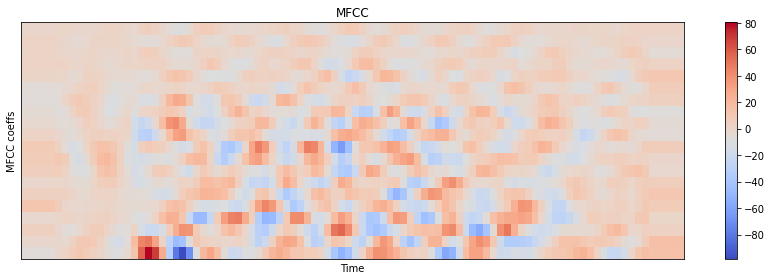

In [129]:
#라이브러리 사용
import matplotlib.pyplot as plt
import librosa.display
import librosa
import numpy as np

sample_rate=16000

x = librosa.load(os.path.join(root_dir, "aa.wav"),sample_rate)[0]
S = librosa.feature.melspectrogram(x, sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20,lifter=22)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

참조사이트 - https://sanghyu.tistory.com/45

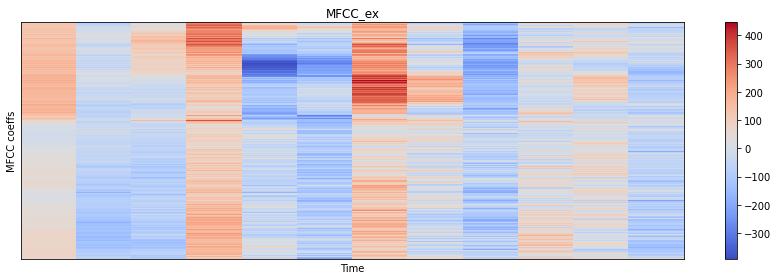

In [153]:
#위에서 만든 MFCC
plt.figure(figsize=(12, 4))
#delta2_mfcc_ex = librosa.feature.delta(mfcc_ex, order=2)
librosa.display.specshow(mfcc_ex)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC_ex')
plt.colorbar()
plt.tight_layout()